In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from torchvision import transforms  # Import the transforms module for data preprocessing
import matplotlib.pyplot as plt
import numpy as np
import os  # Import the os module to operate the file path
from PIL import Image  # Import the Image module in the PIL library for image processing
from tqdm import tqdm  # Progress bar module
from time import sleep 
import time # Used to record training time

In [2]:
# Setting Hyperparameters
EPOCH = 35
BATCH_SIZE = 32
show_size = 12         # number of pictures used to show the comparison of AE reconstruction
LR = 0.01              # Learning rate

In [3]:
# 设置随机数种子
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    # random.seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 2809
setup_seed(SEED)

### Dataset

In [4]:
# The class for loading datasets is used to load datasets 
# whose labels are stored in a separate txt file in the format of "filename\t label"
class CustomDataset(Data.Dataset):
    def __init__(self, image_dir, label_file, transform=None):
        super().__init__()  # Calling the parent class's constructor
        self.image_dir = image_dir  # Path to the image data
        self.label_file = label_file  # The path of the label text
        self.transform = transform  # Data preprocessing operations
        self.samples = self._load_samples()  # Loading dataset sample information

    def _load_samples(self):
        samples = []  # List storing sample information
        with open(self.label_file, 'r') as f:  # Open the label text file
            for line in f:  # Read the contents of a labeled text file line by line
                image_name, label = line.strip().split('\t ')  # Get the image file name and label by separating each line with tabs + spaces
                image_path = os.path.join(self.image_dir, image_name)  # The full path to the stitched image file
                samples.append((image_path, label))  # Combine the image path and label into a tuple and add it to the sample list
        return samples  # Return to sample list

    def __len__(self):
        return len(self.samples)  # Returns the number of samples in the dataset

    def __getitem__(self, index):
        image_path, label = self.samples[index]  # Get the image path and label at the specified index
        image = Image.open(image_path).convert('L')  # Open an image file and convert it to grayscale
        if self.transform:  # If data preprocessing operations are defined
            image = self.transform(image)  # Preprocess the image
        return image, label  # Returns the preprocessed image and label

In [5]:
# Check if CUDA is installed and available for your GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the image data path and label text path
train_image_dir = '../data_train/graphs/'  # Path to the image data
train_label_file = '../data_train/labels.txt'  # The path of the label text
test_image_dir = '../data_test/graphs/' 
test_label_file = '../data_test/labels.txt'  
show_image_dir = '../data_test/graphs_12/'
show_label_file = '../data_test/labels_12.txt'

# Define data preprocessing operations and add other preprocessing operations as needed
transform = transforms.Compose([
    transforms.Resize((40, 40)),  # Resize the images
    transforms.ToTensor(),  # Convert image to tensor
])

# Creating a custom dataset instance
train_dataset = CustomDataset(train_image_dir, train_label_file, transform=transform)
test_dataset = CustomDataset(test_image_dir, test_label_file, transform=transform)
show_dataset = CustomDataset(show_image_dir, show_label_file, transform=transform)

print("Size of train dataset:")
print(train_dataset.__len__())
print("Size of test dataset:")
print(test_dataset.__len__())
print("Size of show dataset:")
print(show_dataset.__len__())

# Creating a Data Loader
# Shuffle the order during training
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
show_loader = Data.DataLoader(dataset=show_dataset, batch_size=show_size, shuffle=False)

Size of train dataset:
18000
Size of test dataset:
600
Size of show dataset:
12


### AE

In [6]:
# Activation function is ReLU
# Hidden space 4 neurons
# 8-layer network
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features=40*40, out_features=680),
            nn.ReLU(),
            nn.Linear(in_features=680, out_features=280),
            nn.ReLU(),
            nn.Linear(in_features=280, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=22),
            nn.ReLU(),
            nn.Linear(in_features=22, out_features=9),
            nn.ReLU(),
            nn.Linear(in_features=9, out_features=4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=4, out_features=9),
            nn.ReLU(),
            nn.Linear(in_features=9, out_features=22),
            nn.ReLU(),
            nn.Linear(in_features=22, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=280),
            nn.ReLU(),
            nn.Linear(in_features=280, out_features=680),
            nn.ReLU(),
            nn.Linear(in_features=680, out_features=40*40),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Create an autoencoder object and move the model to the GPU
model = AutoEncoder().to(device)
# Defining loss function and optimizer
criterion = nn.MSELoss() # The loss function is the mean square error
optimizer = optim.Adam(model.parameters(), lr=LR)

### Training and testing of AE

In [8]:
train_loss_list = [] # The average training loss of every epoch
test_loss_list = []  # The average testing loss of every epoch
loss_list = [] # The average training loss of every batch
time_list = [] # The time afer training every batch

# Training the Autoencoder
start_time = time.time()
for epoch in range(EPOCH):
    train_loss = 0
    count = 0
    for data in tqdm(train_loader):
        img, _ = data
        img = img.to(device)
        img = img.flatten(2, 3)
        # Forward Propagation
        output = model(img)
        loss = criterion(output, img)                       # Calculating Losses
        time_list.append(time.time() - start_time)          # Recording time
        loss_list.append(loss.data)
        count += 1
        train_loss += loss.data
        # Backpropagation and optimizer optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sleep(0.001)
    train_loss_list.append(train_loss/count) # Record the average training loss of this epoch
    print("Epoch[{}/{}], loss:{:.4f}".format(epoch+1, EPOCH, loss.data))
    
    # After each epoch of training, the test set is tested once and the average loss is recorded.
    dataiter = iter(test_loader)
    test_loss = 0
    count = 0
    # Loop through all iterators
    for j in range(len(iter(test_loader))):
        # Get the next batch of images and labels from the iterator
        images, labels = next(dataiter)
        images = images.flatten(2, 3)

        # Use the model to perform inference, 
        # process the acquired image data, and save the result in the output variable
        output = model(images.to(device))
        count += 1
        test_loss += criterion(output, images.to(device)).data
    test_loss_list.append(test_loss/count)

100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:25<00:00, 22.51it/s]


Epoch[1/35], loss:0.0576


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.36it/s]


Epoch[2/35], loss:0.0418


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.23it/s]


Epoch[3/35], loss:0.0468


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.16it/s]


Epoch[4/35], loss:0.0476


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.19it/s]


Epoch[5/35], loss:0.0617


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.02it/s]


Epoch[6/35], loss:0.0552


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 25.85it/s]


Epoch[7/35], loss:0.0468


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.50it/s]


Epoch[8/35], loss:0.0595


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.62it/s]


Epoch[9/35], loss:0.0458


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.09it/s]


Epoch[10/35], loss:0.0458


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.18it/s]


Epoch[11/35], loss:0.0346


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:19<00:00, 29.02it/s]


Epoch[12/35], loss:0.0636


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:19<00:00, 29.14it/s]


Epoch[13/35], loss:0.0484


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:18<00:00, 30.68it/s]


Epoch[14/35], loss:0.0499


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:18<00:00, 30.86it/s]


Epoch[15/35], loss:0.0375


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 25.62it/s]


Epoch[16/35], loss:0.0506


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.29it/s]


Epoch[17/35], loss:0.0369


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:22<00:00, 24.57it/s]


Epoch[18/35], loss:0.0453


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 26.59it/s]


Epoch[19/35], loss:0.0492


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 25.94it/s]


Epoch[20/35], loss:0.0887


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:21<00:00, 25.74it/s]


Epoch[21/35], loss:0.0651


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.95it/s]


Epoch[22/35], loss:0.0773


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.92it/s]


Epoch[23/35], loss:0.0763


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.88it/s]


Epoch[24/35], loss:0.0709


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.97it/s]


Epoch[25/35], loss:0.0753


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 28.12it/s]


Epoch[26/35], loss:0.0871


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.88it/s]


Epoch[27/35], loss:0.0873


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.83it/s]


Epoch[28/35], loss:0.0723


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.82it/s]


Epoch[29/35], loss:0.0857


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.66it/s]


Epoch[30/35], loss:0.0572


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:24<00:00, 22.97it/s]


Epoch[31/35], loss:0.0530


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:22<00:00, 25.34it/s]


Epoch[32/35], loss:0.0484


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.56it/s]


Epoch[33/35], loss:0.0500


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.46it/s]


Epoch[34/35], loss:0.0467


100%|████████████████████████████████████████████████████████████████████████████████| 563/563 [00:20<00:00, 27.00it/s]


Epoch[35/35], loss:0.0885


### Record the loss value of the training process in a csv file

file name:"AE_MSE_ReLU_0.01_680_280_120_50_60_2_9_4.csv" 

Activation Function_Loss Function_Learning Rate_number of networks in each layer

In [9]:
import csv

with open("./epoch_train_test_param/AE_MSE_ReLU_0.01_680_280_120_50_60_2_9_4.csv","w", newline='') as csvfile: 
    writer = csv.writer(csvfile)

    # To write columns_name
    writer.writerow(["epoch","train_loss","test_loss"])
    # To write many rows
    for i in range(EPOCH):
        writer.writerow([i+1, train_loss_list[i].item(), test_loss_list[i].item()])

In [10]:
with open("./time_loss_param/AE_MSE_ReLU_0.01_680_280_120_50_60_2_9_4.csv","w", newline='') as csvfile: 
    writer = csv.writer(csvfile)

    writer.writerow(["time","loss"])
    for i in range(len(time_list)):
        writer.writerow([time_list[i], loss_list[i].item()])

### Show comparison of pictures

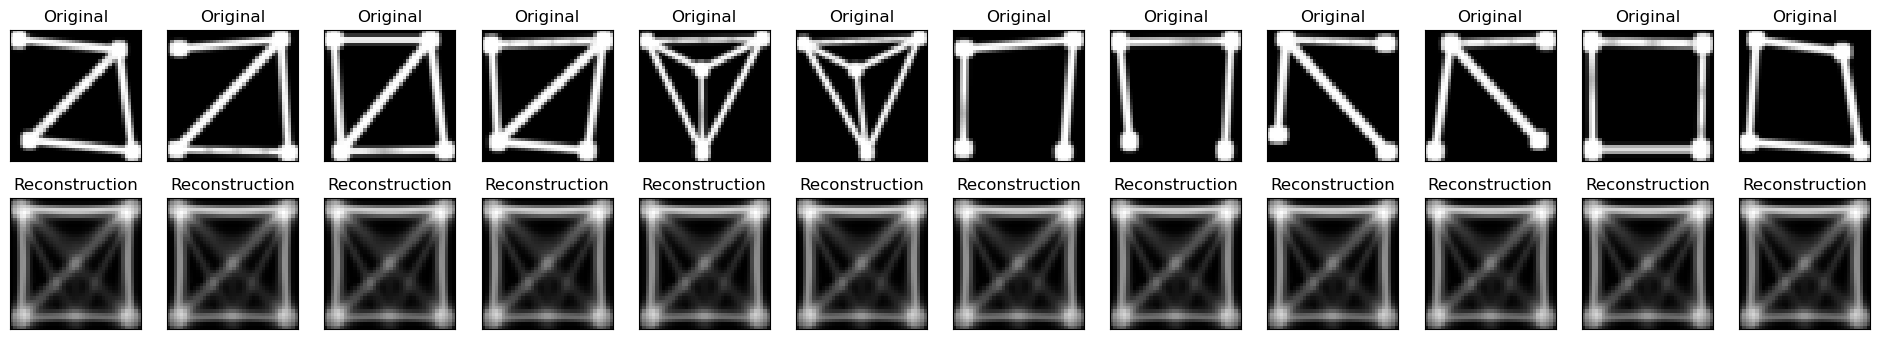

In [11]:
# Iterate over the test dataset and generate an iterator
dataiter = iter(show_loader)

# Loop through all iterators
for j in range(len(iter(show_loader))):
    # Get the next batch of images and labels from the iterator
    images, labels = next(dataiter)
    images = images.flatten(2, 3)

    # Use the model to perform inference, 
    # process the acquired image data, and save the result in the output variable
    output = model(images.to(device))
    output = output.reshape([show_size, 1, 40, 40])
    images = images.reshape([show_size, 1, 40, 40])

    # Create subplots and axes objects 
    # where the first row shows the original image and the second row shows the reconstructed image
    fig, axes = plt.subplots(nrows=2, ncols=show_size, sharex=True, sharey=True, figsize=(24,4))

    # Loop through the 12 images in the iterator, 
    # draw the original image and the reconstructed image and add a title
    for i in range(show_size):
        # Display original image
        axes[0,i].imshow(images[i].squeeze().numpy(), cmap='gray')
        axes[0,i].set_title("Original")
        axes[0,i].get_xaxis().set_visible(False)
        axes[0,i].get_yaxis().set_visible(False)

        # Display the reconstructed image
        axes[1,i].imshow(output[i].squeeze().cpu().detach().numpy(), cmap='gray')
        axes[1,i].set_title("Reconstruction")
        axes[1,i].get_xaxis().set_visible(False)
        axes[1,i].get_yaxis().set_visible(False)

    plt.savefig('./pic_reconstruction/AE_MSE_ReLU_0.01_680_280_120_50_60_2_9_4_ep35.png', dpi=300)
    # Display the generated subgraph
    plt.show()

### Other optional network structures

#### model 0

In [12]:
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=1200),
#             nn.Sigmoid(),
#             nn.Linear(in_features=1200, out_features=900),
#             nn.Sigmoid(),
#             nn.Linear(in_features=900, out_features=600),
#             nn.Sigmoid(),
#             nn.Linear(in_features=600, out_features=400),
#             nn.Sigmoid(),
#             nn.Linear(in_features=400, out_features=240),
#             nn.Sigmoid(),
#             nn.Linear(in_features=240, out_features=160),
#             nn.Sigmoid(),
#             nn.Linear(in_features=160, out_features=100),
#             nn.Sigmoid(),
#             nn.Linear(in_features=100, out_features=N_DIM_LS),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=N_DIM_LS, out_features=100),
#             nn.Sigmoid(),
#             nn.Linear(in_features=100, out_features=160),
#             nn.Sigmoid(),
#             nn.Linear(in_features=160, out_features=240),
#             nn.Sigmoid(),
#             nn.Linear(in_features=240, out_features=400),
#             nn.Sigmoid(),
#             nn.Linear(in_features=400, out_features=600),
#             nn.Sigmoid(),
#             nn.Linear(in_features=600, out_features=900),
#             nn.Sigmoid(),
#             nn.Linear(in_features=900, out_features=1200),
#             nn.Sigmoid(),
#             nn.Linear(in_features=1200, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

#### Hidden space 4 neurons

In [13]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 2-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [14]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 3-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [15]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 4-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=220),
#             nn.ReLU(),
#             nn.Linear(in_features=220, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=220),
#             nn.ReLU(),
#             nn.Linear(in_features=220, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [16]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 5-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=360),
#             nn.ReLU(),
#             nn.Linear(in_features=360, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=18),
#             nn.ReLU(),
#             nn.Linear(in_features=18, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=18),
#             nn.ReLU(),
#             nn.Linear(in_features=18, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=360),
#             nn.ReLU(),
#             nn.Linear(in_features=360, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [17]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 6-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=480),
#             nn.ReLU(),
#             nn.Linear(in_features=480, out_features=140),
#             nn.ReLU(),
#             nn.Linear(in_features=140, out_features=40),
#             nn.ReLU(),
#             nn.Linear(in_features=40, out_features=12),
#             nn.ReLU(),
#             nn.Linear(in_features=12, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=12),
#             nn.ReLU(),
#             nn.Linear(in_features=12, out_features=40),
#             nn.ReLU(),
#             nn.Linear(in_features=40, out_features=140),
#             nn.ReLU(),
#             nn.Linear(in_features=140, out_features=480),
#             nn.ReLU(),
#             nn.Linear(in_features=480, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [18]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 7-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=580),
#             nn.ReLU(),
#             nn.Linear(in_features=580, out_features=210),
#             nn.ReLU(),
#             nn.Linear(in_features=210, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=12),
#             nn.ReLU(),
#             nn.Linear(in_features=12, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=12),
#             nn.ReLU(),
#             nn.Linear(in_features=12, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=210),
#             nn.ReLU(),
#             nn.Linear(in_features=210, out_features=580),
#             nn.ReLU(),
#             nn.Linear(in_features=580, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [19]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 8-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=680),
#             nn.ReLU(),
#             nn.Linear(in_features=680, out_features=280),
#             nn.ReLU(),
#             nn.Linear(in_features=280, out_features=120),
#             nn.ReLU(),
#             nn.Linear(in_features=120, out_features=50),
#             nn.ReLU(),
#             nn.Linear(in_features=50, out_features=22),
#             nn.ReLU(),
#             nn.Linear(in_features=22, out_features=9),
#             nn.ReLU(),
#             nn.Linear(in_features=9, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=9),
#             nn.ReLU(),
#             nn.Linear(in_features=9, out_features=22),
#             nn.ReLU(),
#             nn.Linear(in_features=22, out_features=50),
#             nn.ReLU(),
#             nn.Linear(in_features=50, out_features=120),
#             nn.ReLU(),
#             nn.Linear(in_features=120, out_features=280),
#             nn.ReLU(),
#             nn.Linear(in_features=280, out_features=680),
#             nn.ReLU(),
#             nn.Linear(in_features=680, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [20]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 9-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=790),
#             nn.ReLU(),
#             nn.Linear(in_features=790, out_features=360),
#             nn.ReLU(),
#             nn.Linear(in_features=360, out_features=170),
#             nn.ReLU(),
#             nn.Linear(in_features=170, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=38),
#             nn.ReLU(),
#             nn.Linear(in_features=38, out_features=18),
#             nn.ReLU(),
#             nn.Linear(in_features=18, out_features=8),
#             nn.ReLU(),
#             nn.Linear(in_features=8, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=8),
#             nn.ReLU(),
#             nn.Linear(in_features=8, out_features=18),
#             nn.ReLU(),
#             nn.Linear(in_features=18, out_features=38),
#             nn.ReLU(),
#             nn.Linear(in_features=38, out_features=80),
#             nn.ReLU(),
#             nn.Linear(in_features=80, out_features=170),
#             nn.ReLU(),
#             nn.Linear(in_features=170, out_features=360),
#             nn.ReLU(),
#             nn.Linear(in_features=360, out_features=790),
#             nn.ReLU(),
#             nn.Linear(in_features=790, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [21]:
# # Activation function is ReLU
# # Hidden space 4 neurons
# # 10-layer network
# class AutoEncoder(nn.Module):
#     def __init__(self):
#         super(AutoEncoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(in_features=40*40, out_features=830),
#             nn.ReLU(),
#             nn.Linear(in_features=830, out_features=430),
#             nn.ReLU(),
#             nn.Linear(in_features=430, out_features=220),
#             nn.ReLU(),
#             nn.Linear(in_features=220, out_features=110),
#             nn.ReLU(),
#             nn.Linear(in_features=110, out_features=60),
#             nn.ReLU(),
#             nn.Linear(in_features=60, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=15),
#             nn.ReLU(),
#             nn.Linear(in_features=15, out_features=8),
#             nn.ReLU(),
#             nn.Linear(in_features=8, out_features=4),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=4, out_features=8),
#             nn.ReLU(),
#             nn.Linear(in_features=8, out_features=15),
#             nn.ReLU(),
#             nn.Linear(in_features=15, out_features=30),
#             nn.ReLU(),
#             nn.Linear(in_features=30, out_features=60),
#             nn.ReLU(),
#             nn.Linear(in_features=60, out_features=110),
#             nn.ReLU(),
#             nn.Linear(in_features=110, out_features=220),
#             nn.ReLU(),
#             nn.Linear(in_features=220, out_features=430),
#             nn.ReLU(),
#             nn.Linear(in_features=430, out_features=830),
#             nn.ReLU(),
#             nn.Linear(in_features=830, out_features=40*40),
#             nn.Sigmoid(),       # compress to a range (0, 1)
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x